# Backtest Analysis - 2025-10-02

Analysis of LSTM trading model performance over 2020-2023 period.

**Backtest Parameters:**
- Period: 2020-01-01 to 2023-12-31 (4 years)
- Initial Capital: $100,000
- Total Trades: 25,538
- Symbols: 22 stocks across tech, financials, healthcare, consumer, and energy sectors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [2]:
# Load configuration
with open('config.json', 'r') as f:
    config = json.load(f)

# Load all CSVs
trades = pd.read_csv('trades.csv', parse_dates=['timestamp'])
portfolio = pd.read_csv('portfolio_history.csv', parse_dates=['timestamp'])
predictions = pd.read_csv('predictions_vs_actual.csv', parse_dates=['timestamp'])
market_data = pd.read_csv('market_data.csv')

print(f"Loaded {len(trades)} trades")
print(f"Portfolio history: {len(portfolio)} days")
print(f"Predictions: {len(predictions)} records")
print(f"\nConfig summary:")
print(f"  Initial capital: ${config['BACKTEST']['initial_capital']:,.0f}")
print(f"  Commission: {config['BACKTEST']['commission']*100}%")
print(f"  Slippage: {config['BACKTEST']['slippage']*100}%")
print(f"  Investment per position: {config['STRATEGY']['investment_size']*100}%")
print(f"  Stop loss: {config['STRATEGY']['stop_loss']}x")
print(f"  Take profit: {config['STRATEGY']['take_profit']}x")

Loaded 25538 trades
Portfolio history: 804 days
Predictions: 17642 records

Config summary:
  Initial capital: $100,000
  Commission: 0.5%
  Slippage: 0.1%
  Investment per position: 5.0%
  Stop loss: 0.8x
  Take profit: 1.2x


## 2. Overall Performance Metrics

In [3]:
# Portfolio performance
initial_capital = config['BACKTEST']['initial_capital']
final_value = portfolio['total_value'].iloc[-1]
total_return = (final_value - initial_capital) / initial_capital
years = (portfolio['timestamp'].iloc[-1] - portfolio['timestamp'].iloc[0]).days / 365.25
cagr = (final_value / initial_capital) ** (1 / years) - 1

# Calculate daily returns
portfolio['returns'] = portfolio['total_value'].pct_change()
daily_returns = portfolio['returns'].dropna()

# Risk metrics
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
portfolio['cummax'] = portfolio['total_value'].cummax()
portfolio['drawdown'] = (portfolio['total_value'] - portfolio['cummax']) / portfolio['cummax']
max_drawdown = portfolio['drawdown'].min()

# Print summary
print("=" * 60)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Initial Capital:        ${initial_capital:>15,.2f}")
print(f"Final Value:            ${final_value:>15,.2f}")
print(f"Total Return:           {total_return:>15.2%}")
print(f"CAGR:                   {cagr:>15.2%}")
print(f"Sharpe Ratio:           {sharpe_ratio:>15.2f}")
print(f"Max Drawdown:           {max_drawdown:>15.2%}")
print(f"Volatility (annualized):{daily_returns.std() * np.sqrt(252):>15.2%}")
print(f"Best Day:               {daily_returns.max():>15.2%}")
print(f"Worst Day:              {daily_returns.min():>15.2%}")
print("=" * 60)

PORTFOLIO PERFORMANCE SUMMARY
Initial Capital:        $     100,000.00
Final Value:            $     137,012.39
Total Return:                    37.01%
CAGR:                            10.38%
Sharpe Ratio:                      0.69
Max Drawdown:                   -81.81%
Volatility (annualized):        289.85%
Best Day:                       418.06%
Worst Day:                      -80.67%


## 3. Trade Analysis

In [4]:
# Match buy/sell pairs to calculate PnL
trades_sorted = trades.sort_values(['symbol', 'timestamp']).copy()
completed_trades = []

for symbol in trades_sorted['symbol'].unique():
    symbol_trades = trades_sorted[trades_sorted['symbol'] == symbol].copy()
    buys = symbol_trades[symbol_trades['action'] == 'BUY'].copy()
    sells = symbol_trades[symbol_trades['action'] == 'SELL'].copy()
    
    # Match each sell with most recent buy
    for _, sell in sells.iterrows():
        prior_buys = buys[buys['timestamp'] < sell['timestamp']]
        if len(prior_buys) > 0:
            buy = prior_buys.iloc[-1]
            
            holding_period = (sell['timestamp'] - buy['timestamp']).total_seconds() / 86400
            pnl = (sell['price'] - buy['price']) * sell['shares'] - sell['commission'] - buy['commission']
            pnl_pct = (sell['price'] / buy['price'] - 1)
            
            completed_trades.append({
                'symbol': symbol,
                'entry_date': buy['timestamp'],
                'exit_date': sell['timestamp'],
                'entry_price': buy['price'],
                'exit_price': sell['price'],
                'shares': sell['shares'],
                'holding_days': holding_period,
                'pnl': pnl,
                'pnl_pct': pnl_pct,
                'win': pnl > 0
            })

completed_df = pd.DataFrame(completed_trades)

# Trade statistics
if len(completed_df) > 0:
    total_trades = len(completed_df)
    winning_trades = completed_df['win'].sum()
    losing_trades = total_trades - winning_trades
    win_rate = winning_trades / total_trades
    
    avg_win = completed_df[completed_df['win']]['pnl'].mean() if winning_trades > 0 else 0
    avg_loss = completed_df[~completed_df['win']]['pnl'].mean() if losing_trades > 0 else 0
    profit_factor = abs(completed_df[completed_df['win']]['pnl'].sum() / completed_df[~completed_df['win']]['pnl'].sum()) if losing_trades > 0 else float('inf')
    
    print("=" * 60)
    print("TRADE ANALYSIS")
    print("=" * 60)
    print(f"Total Completed Trades: {total_trades:>15,}")
    print(f"Winning Trades:         {winning_trades:>15,} ({win_rate:.2%})")
    print(f"Losing Trades:          {losing_trades:>15,} ({1-win_rate:.2%})")
    print(f"Average Win:            ${avg_win:>15,.2f}")
    print(f"Average Loss:           ${avg_loss:>15,.2f}")
    print(f"Profit Factor:          {profit_factor:>15.2f}")
    print(f"Best Trade:             ${completed_df['pnl'].max():>15,.2f}")
    print(f"Worst Trade:            ${completed_df['pnl'].min():>15,.2f}")
    print(f"Avg Holding Period:     {completed_df['holding_days'].mean():>15.1f} days")
    print(f"Median Holding Period:  {completed_df['holding_days'].median():>15.1f} days")
    print("=" * 60)
else:
    print("No completed trades found (BUY-SELL pairs)")

TRADE ANALYSIS
Total Completed Trades:           8,038
Winning Trades:                   3,429 (42.66%)
Losing Trades:                    4,609 (57.34%)
Average Win:            $           1.36
Average Loss:           $          -1.37
Profit Factor:                     0.74
Best Trade:             $          71.16
Worst Trade:            $        -118.65
Avg Holding Period:                 1.6 days
Median Holding Period:              1.0 days


## 4. Performance by Symbol


Performance by Symbol:
        Total PnL  Avg PnL  Trades  Win Rate  Avg Hold Days
symbol                                                     
KO         463.70     0.88     525      0.73           1.00
CAT        461.75     1.12     412      0.59           2.35
META       357.95     1.23     290      0.80           1.00
WMT        262.53     0.40     658      0.81           1.53
LIN        167.74     0.58     287      0.29           2.40
JPM        162.92     0.50     323      0.25           1.10
BA         140.02     0.58     240      0.59           1.02
NVDA       121.76     0.60     203      0.22           1.28
GS          86.38     0.30     286      0.33           1.09
GOOGL        4.57     0.01     454      0.71           1.10
BAC        -78.43    -0.22     350      0.38           1.01
CVX        -86.25    -0.20     422      0.49           1.56
UNH        -91.84    -1.56      59      0.00           1.00
MSFT      -100.90    -0.32     313      0.32           4.14
WFC       -144.6

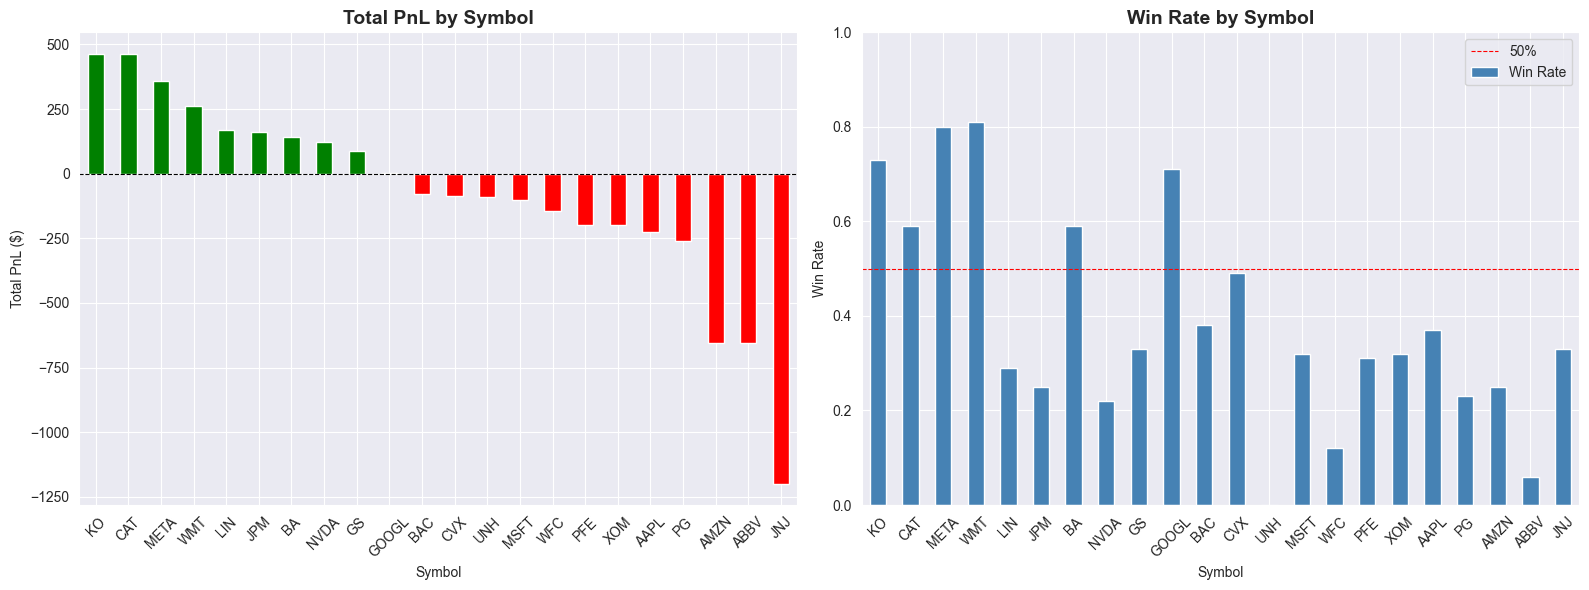

In [5]:
if len(completed_df) > 0:
    # Performance by symbol
    symbol_perf = completed_df.groupby('symbol').agg({
        'pnl': ['sum', 'mean', 'count'],
        'win': 'mean',
        'holding_days': 'mean'
    }).round(2)
    
    symbol_perf.columns = ['Total PnL', 'Avg PnL', 'Trades', 'Win Rate', 'Avg Hold Days']
    symbol_perf = symbol_perf.sort_values('Total PnL', ascending=False)
    
    print("\nPerformance by Symbol:")
    print(symbol_perf.to_string())
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Total PnL by symbol
    symbol_perf['Total PnL'].plot(kind='bar', ax=axes[0], color=['g' if x > 0 else 'r' for x in symbol_perf['Total PnL']])
    axes[0].set_title('Total PnL by Symbol', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Symbol')
    axes[0].set_ylabel('Total PnL ($)')
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Win rate by symbol
    symbol_perf['Win Rate'].plot(kind='bar', ax=axes[1], color='steelblue')
    axes[1].set_title('Win Rate by Symbol', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Symbol')
    axes[1].set_ylabel('Win Rate')
    axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=0.8, label='50%')
    axes[1].legend()
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

## 5. Equity Curve and Drawdown

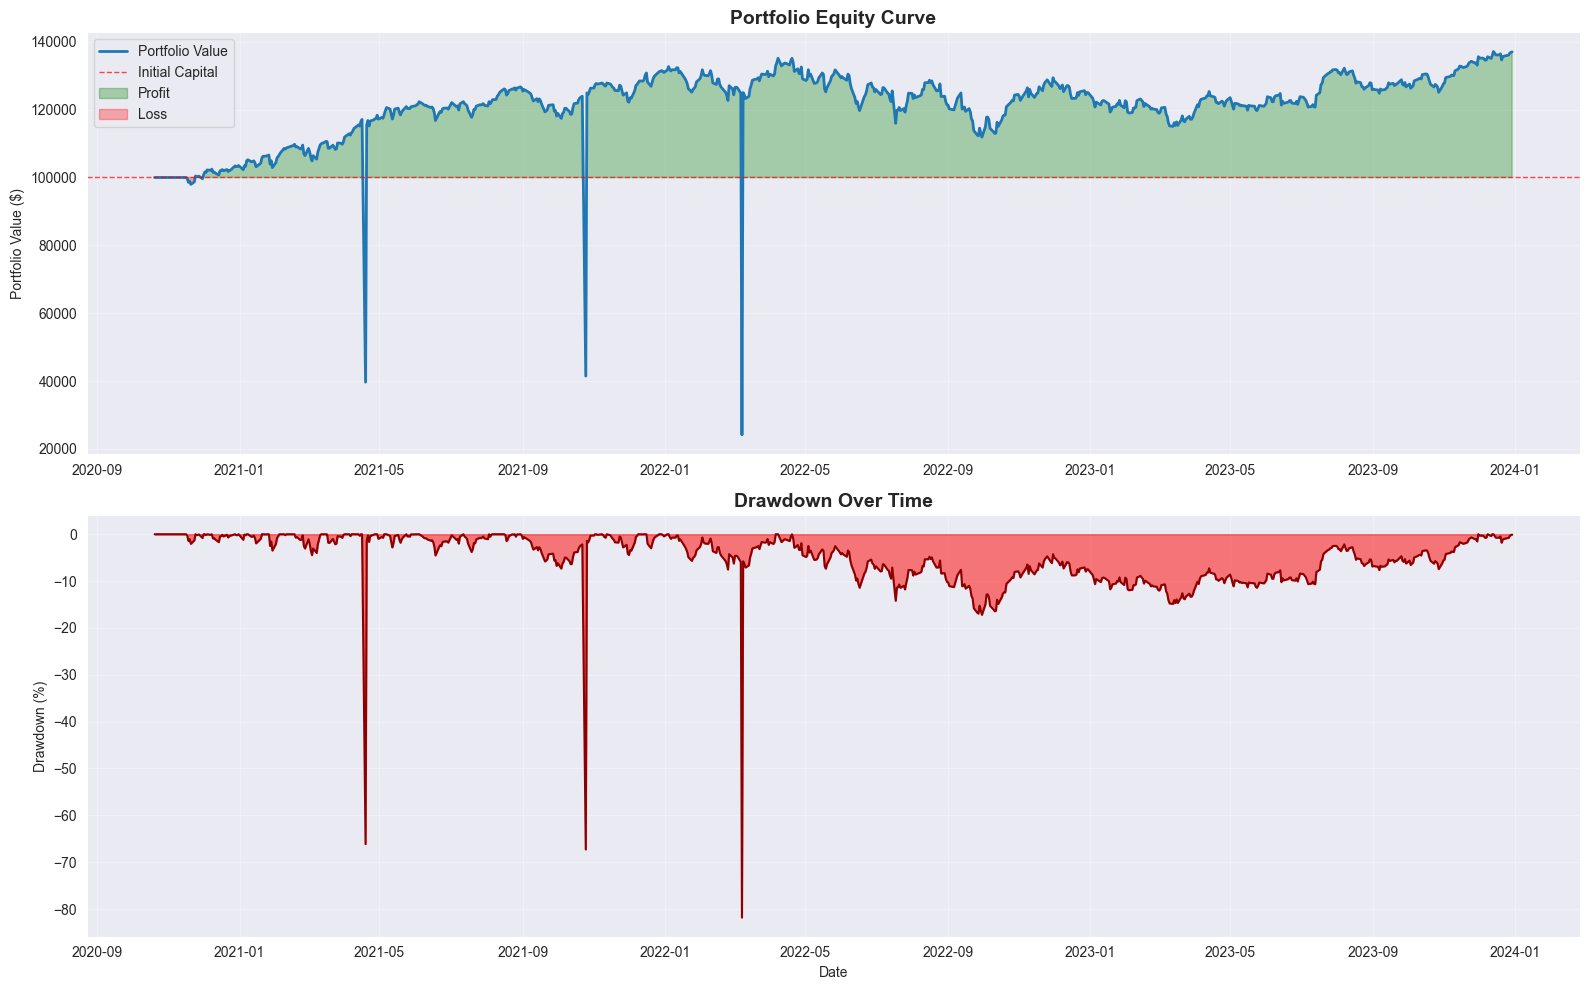

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Equity curve
axes[0].plot(portfolio['timestamp'], portfolio['total_value'], linewidth=2, label='Portfolio Value')
axes[0].axhline(y=initial_capital, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Initial Capital')
axes[0].fill_between(portfolio['timestamp'], initial_capital, portfolio['total_value'], 
                       where=portfolio['total_value'] >= initial_capital, alpha=0.3, color='green', label='Profit')
axes[0].fill_between(portfolio['timestamp'], initial_capital, portfolio['total_value'], 
                       where=portfolio['total_value'] < initial_capital, alpha=0.3, color='red', label='Loss')
axes[0].set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown
axes[1].fill_between(portfolio['timestamp'], 0, portfolio['drawdown'] * 100, color='red', alpha=0.5)
axes[1].plot(portfolio['timestamp'], portfolio['drawdown'] * 100, color='darkred', linewidth=1.5)
axes[1].set_title('Drawdown Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Returns Distribution

ValueError: The 'color' keyword argument must have one color per dataset, but 1 datasets and 50 colors were provided

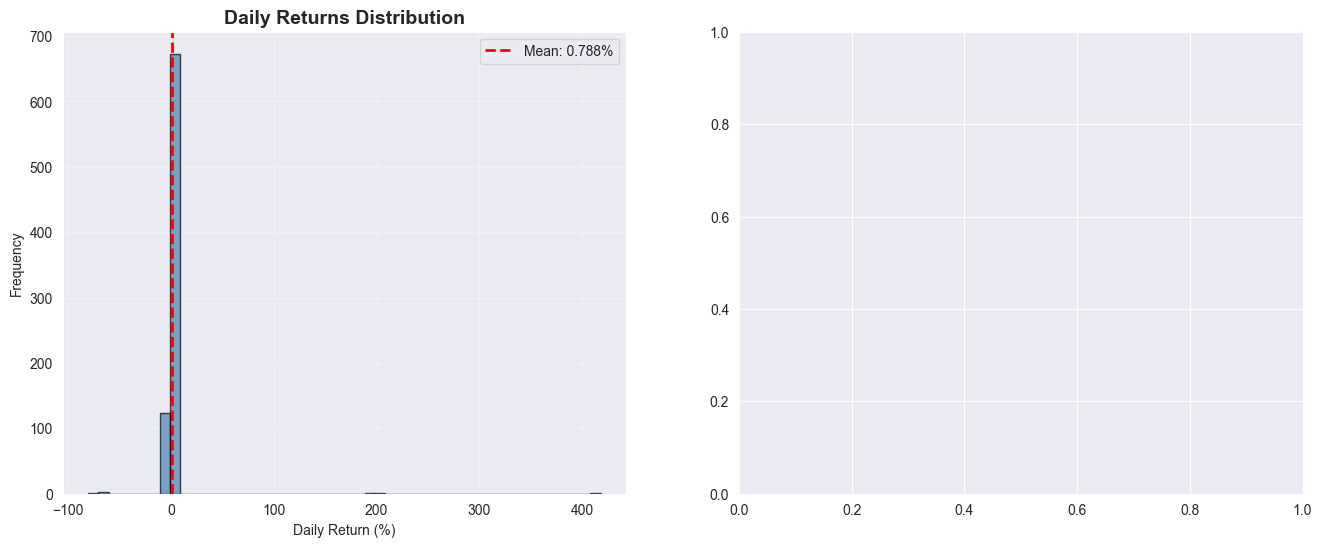

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Daily returns histogram
axes[0].hist(daily_returns * 100, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=daily_returns.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {daily_returns.mean()*100:.3f}%')
axes[0].set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trade PnL distribution
if len(completed_df) > 0:
    axes[1].hist(completed_df['pnl'], bins=50, edgecolor='black', alpha=0.7, 
                 color=['green' if x > 0 else 'red' for x in np.histogram(completed_df['pnl'], bins=50)[0]])
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
    axes[1].axvline(x=completed_df['pnl'].mean(), color='blue', linestyle='--', linewidth=2, 
                    label=f'Mean: ${completed_df["pnl"].mean():.2f}')
    axes[1].set_title('Trade PnL Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('PnL per Trade ($)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Prediction Analysis


Total prediction records: 17,642
Valid signals (non-HOLD): 17,224

Signal distribution:
signal
BUY     14068
SELL     3156
HOLD      418
Name: count, dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_21700\820650552.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  signal_counts = predictions.groupby([pd.Grouper(key='timestamp', freq='M'), 'signal']).size().unstack(fill_value=0)


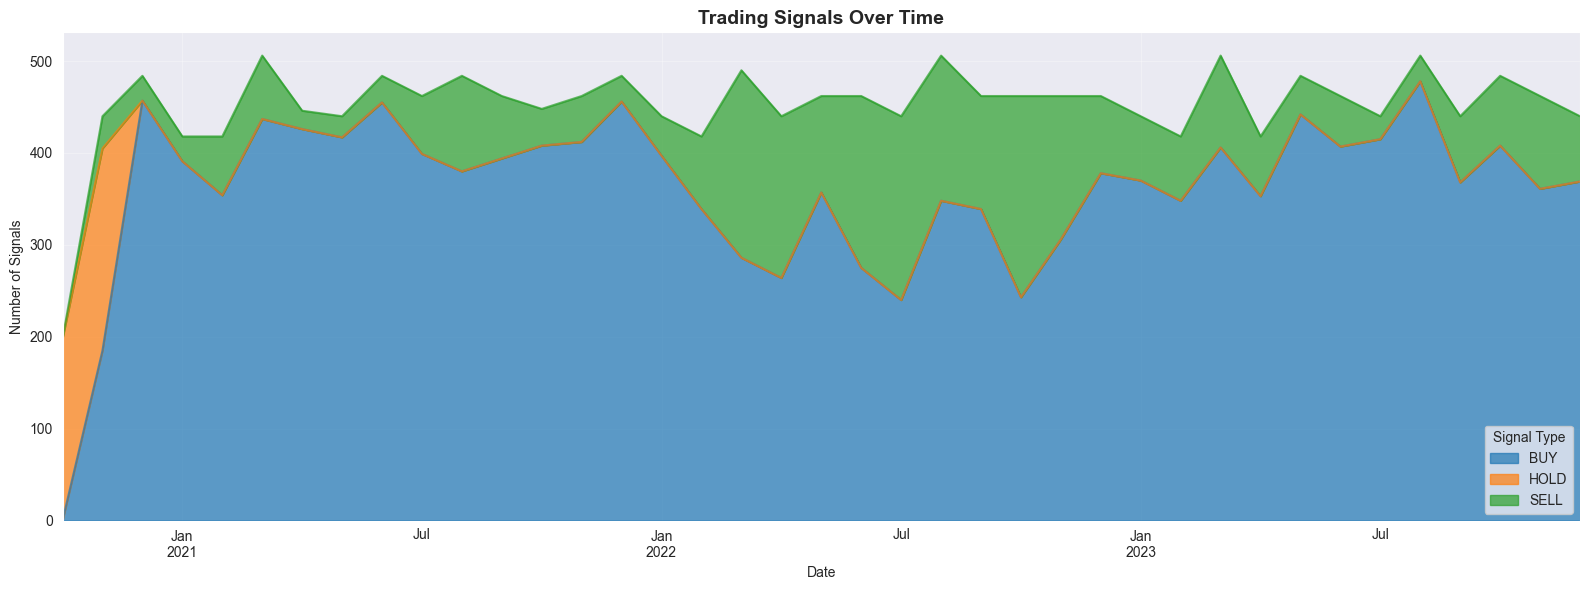

In [8]:
# Filter out NaN predictions (warmup period)
valid_preds = predictions[predictions['signal'] != 'HOLD'].copy()

print(f"\nTotal prediction records: {len(predictions):,}")
print(f"Valid signals (non-HOLD): {len(valid_preds):,}")
print(f"\nSignal distribution:")
print(predictions['signal'].value_counts())

# Signal distribution over time
if len(valid_preds) > 0:
    signal_counts = predictions.groupby([pd.Grouper(key='timestamp', freq='M'), 'signal']).size().unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    signal_counts.plot(kind='area', stacked=True, ax=ax, alpha=0.7)
    ax.set_title('Trading Signals Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Signals')
    ax.legend(title='Signal Type')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Monthly Performance

C:\Users\andre\AppData\Local\Temp\ipykernel_21700\1434398872.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  portfolio_monthly = portfolio.set_index('timestamp').resample('M').last()


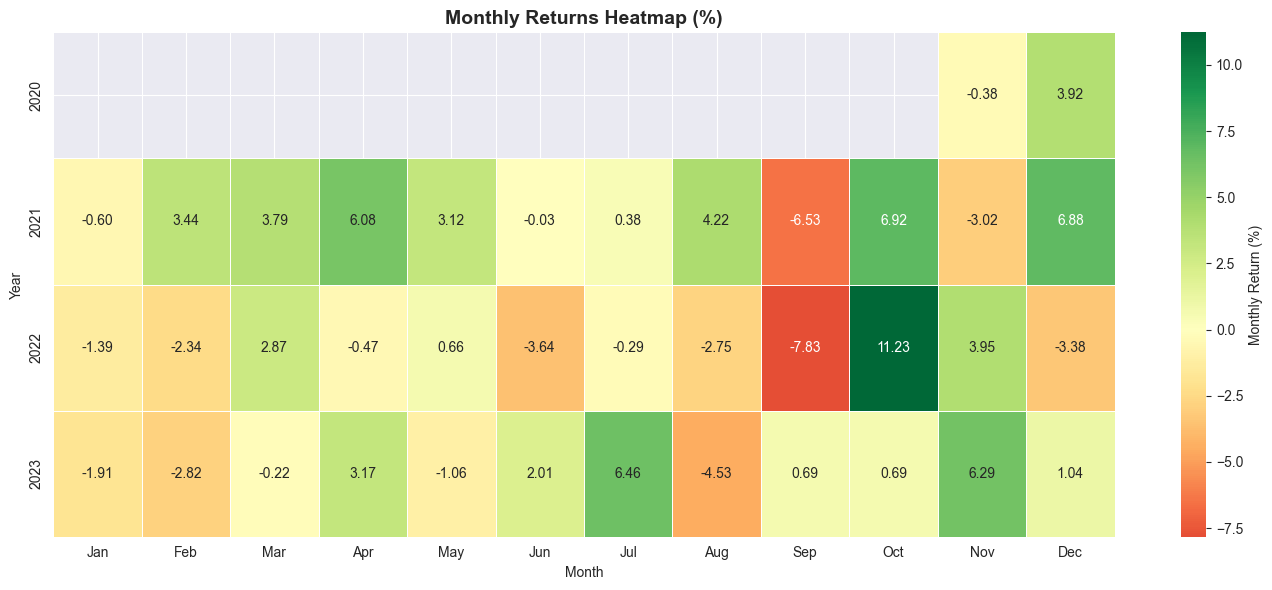


Annual Returns:
  2021: 26.47%
  2022: -4.51%
  2023: 9.59%


C:\Users\andre\AppData\Local\Temp\ipykernel_21700\1434398872.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = portfolio.set_index('timestamp').resample('Y')['total_value'].last().pct_change().dropna()


In [9]:
# Resample to monthly returns
portfolio_monthly = portfolio.set_index('timestamp').resample('M').last()
portfolio_monthly['monthly_return'] = portfolio_monthly['total_value'].pct_change()

# Create monthly heatmap
monthly_returns = portfolio_monthly['monthly_return'].dropna()
monthly_pivot = pd.DataFrame({
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month,
    'Return': monthly_returns.values
}).pivot(index='Year', columns='Month', values='Return')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pivot.columns = [month_names[i-1] for i in monthly_pivot.columns]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(monthly_pivot * 100, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Monthly Return (%)'}, linewidths=0.5, ax=ax)
ax.set_title('Monthly Returns Heatmap (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Year')
plt.tight_layout()
plt.show()

print("\nAnnual Returns:")
annual_returns = portfolio.set_index('timestamp').resample('Y')['total_value'].last().pct_change().dropna()
for date, ret in annual_returns.items():
    print(f"  {date.year}: {ret:.2%}")

## 9. Summary and Recommendations

In [10]:
print("=" * 60)
print("MODEL PERFORMANCE ASSESSMENT")
print("=" * 60)

# Overall assessment
if total_return > 0:
    print(f"\n✓ POSITIVE TOTAL RETURN: {total_return:.2%}")
else:
    print(f"\n✗ NEGATIVE TOTAL RETURN: {total_return:.2%}")

if cagr > 0.05:
    print(f"✓ STRONG CAGR: {cagr:.2%} (above 5% threshold)")
else:
    print(f"✗ WEAK CAGR: {cagr:.2%} (below 5% threshold)")

if win_rate > 0.5:
    print(f"✓ POSITIVE WIN RATE: {win_rate:.2%}")
else:
    print(f"✗ NEGATIVE WIN RATE: {win_rate:.2%}")

if sharpe_ratio > 1.0:
    print(f"✓ GOOD RISK-ADJUSTED RETURNS: Sharpe = {sharpe_ratio:.2f}")
elif sharpe_ratio > 0:
    print(f"~ MODERATE RISK-ADJUSTED RETURNS: Sharpe = {sharpe_ratio:.2f}")
else:
    print(f"✗ POOR RISK-ADJUSTED RETURNS: Sharpe = {sharpe_ratio:.2f}")

if max_drawdown > -0.2:
    print(f"✓ REASONABLE DRAWDOWN: {max_drawdown:.2%}")
else:
    print(f"✗ LARGE DRAWDOWN: {max_drawdown:.2%} (risk management needed)")

if profit_factor > 1.5:
    print(f"✓ STRONG PROFIT FACTOR: {profit_factor:.2f}")
elif profit_factor > 1.0:
    print(f"~ MODERATE PROFIT FACTOR: {profit_factor:.2f}")
else:
    print(f"✗ WEAK PROFIT FACTOR: {profit_factor:.2f}")

print("\n" + "=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)

recommendations = []

if win_rate < 0.5:
    recommendations.append("- Improve signal quality: Win rate below 50% suggests poor entry/exit timing")

if abs(avg_loss) > avg_win:
    recommendations.append("- Tighten stop losses: Average loss exceeds average win")

if max_drawdown < -0.3:
    recommendations.append("- Reduce position sizing: Drawdown exceeds 30%")

if sharpe_ratio < 1.0:
    recommendations.append("- Improve risk-adjusted returns: Consider more selective entry criteria")

if profit_factor < 1.5:
    recommendations.append("- Enhance profit factor: Review take-profit and stop-loss levels")

# Check symbol performance variance
if len(completed_df) > 0:
    losing_symbols = symbol_perf[symbol_perf['Total PnL'] < 0]
    if len(losing_symbols) > len(symbol_perf) * 0.5:
        recommendations.append(f"- Filter underperforming symbols: {len(losing_symbols)} of {len(symbol_perf)} symbols are unprofitable")

if len(recommendations) == 0:
    print("\n✓ Model performing well across all key metrics!")
else:
    print()
    for rec in recommendations:
        print(rec)

print("\n" + "=" * 60)

MODEL PERFORMANCE ASSESSMENT

✓ POSITIVE TOTAL RETURN: 37.01%
✓ STRONG CAGR: 10.38% (above 5% threshold)
✗ NEGATIVE WIN RATE: 42.66%
~ MODERATE RISK-ADJUSTED RETURNS: Sharpe = 0.69
✗ LARGE DRAWDOWN: -81.81% (risk management needed)
✗ WEAK PROFIT FACTOR: 0.74

RECOMMENDATIONS

- Improve signal quality: Win rate below 50% suggests poor entry/exit timing
- Tighten stop losses: Average loss exceeds average win
- Reduce position sizing: Drawdown exceeds 30%
- Improve risk-adjusted returns: Consider more selective entry criteria
- Enhance profit factor: Review take-profit and stop-loss levels
- Filter underperforming symbols: 12 of 22 symbols are unprofitable

